In [1]:
import math
import numpy as np

In [2]:
class Node(object):
    def __init__(self,**kwargs):
        for key, value in kwargs.items():
            vars(self)[key]=value

In [3]:
class Element(object):
    def __init__(self,**kwargs):
        for key, value in kwargs.items():
            vars(self)[key]=value

In [4]:
class ElementTrussXY(Element):
    def __init__(self,**kwargs):
        Element.__init__(self,**kwargs)
    
        self.mdof=4
        self.ke=np.zeros((4,4),float)
        self.ok=np.zeros((4,4),float)
        self.ot=np.zeros((4,4),float)
        self.jdofv=np.zeros((4),int)
    
    
    def computeStiffnessMatrix(self,NODE):
        
        self.c=np.zeros((self.mdof,self.mdof),float)
        
        for i in range(self.mdof):
            for j in range(self.mdof):
                self.c[i,j]=0.0
                
        n1=self.nodes[0]
        n2=self.nodes[1]
        self.jdofv[0]=2*n1-1
        self.jdofv[1]=2*n1
        self.jdofv[2]=2*n2-1
        self.jdofv[3]=2*n2
        
        xx=NODE[n2].x-NODE[n1].x
        yy=NODE[n2].y-NODE[n1].y
        
        A=self.A
    
        E=self.E
         
        L=math.sqrt((xx*xx+yy*yy))
        for i in range(4):
            self.ok[i,j]=0.0
            self.ot[i,j]=0.0
        self.ot[i,i]=1.0
        
        C = xx / L
        S = yy / L
        self.ot[0,0]=C
        self.ot[0,1]=S
        self.ot[1,0]=-S
        self.ot[1,1]=C
        self.ot[2,2]=C
        self.ot[2,3]=S
        self.ot[3,2]=-S
        self.ot[3,3]=C
        
        AE_by_L = A * E / L
        
        self.ke[0,0]=      AE_by_L
        self.ke[0,2]=     -AE_by_L
        
        self.ke[2,0]=     -AE_by_L
        self.ke[2,2]=      AE_by_L
        
        for i in range(4):
            for j in range(4):
                self.c[i,j]=0.0
                for k in range(4):
                    self.c[i,j]=self.c[i,j]+self.ot[k,i]*self.ke[k,j]
                    
        for i in range(4):
            for j in range(4):
                self.ok[i,j]=0.0
                for k in range(4):
                    self.ok[i,j]=self.ok[i,j]+self.c[i,k]*self.ot[k,j]
                    
        del self.c
        
    def assembleStiffness(self,gk):
        
        for i in range(self.mdof):
            ii=self.jdofv[i]
            if ii > 0:
                for j in range(self.mdof):
                    jj=self.jdofv[j]
                    if jj > 0:
                        gk[ii-1,jj-1]=gk[ii-1,jj-1]+self.ok[i,j]
                        
    def computeMemberForces(self,NODE):
            self.computeStiffnessMatrix(NODE)
            mfg=[0,0,0,0]
            mfl=[0,0,0,0]
            disp=[0,0,0,0]
            n1=self.nodes[0]
            n2=self.nodes[1]
            N1=NODE[n1]
            N2=NODE[n2]
            disp[0]=N1.Dx
            disp[1]=N1.Dy
            disp[2]=N2.Dx
            disp[3]=N2.Dy
            
            for i in range(4):
                mfg[i]=0.0
                for j in range(4):
                    mfg[i]=mfg[i]+self.ok[i,j]*disp[j]
                    
            for i in range(4):
                mfl[i]=0.0
                for j in range(4):
                    mfl[i]=mfl[i]+self.ot[i,j]*mfg[j]
                    
            self.mfl=mfl

In [5]:
class Structure(object):
    
    def __init__(self,**kwargs):
        self.title='Untitled'
        self.numnode=0
        self.numelem=0
        self.NODE=dict()
        self.ELEM=dict()
        self.NODE_LIST=list()
        self.ELEM_LIST=list()
        
    def node(self, **kwargs):
        if 'NODE' not in vars(self):
            self.NODE=dict()
        if 'NODE_LIST' not in vars(self):
            self.NODE_LIST=list()
            
        if 'nid' in kwargs:
            nid=kwargs['nid']
            self.NODE[nid]=Node(**kwargs)
            self.NODE_LIST.append(nid)
            self.numnode=self.numnode+1
            
            
    def element(self, **kwargs):
        if 'ELEM' not in vars(self):
            self.ELEM=dict()
        if 'ELEM_LIST' not in vars(self):
            self.ELEM_LIST=list()
            
        if 'eid' in kwargs:
            eid=kwargs['eid']
            if 'etype' in kwargs:
                self.etype=kwargs['etype']
            if self.etype == 'TrussXY':
                self.ELEM[eid]=ElementTrussXY(**kwargs)
            self.ELEM_LIST.append(eid)
            self.numelem=self.numelem+1
            
    def solve(self,**kwargs):
        self.ndof=2*self.numnode
        self.gk=np.zeros((self.ndof,self.ndof),float)
        self.gp=np.zeros((self.ndof,1),float)
        
        for eid in self.ELEM_LIST:
            self.ELEM[eid].computeStiffnessMatrix(self.NODE)
            self.ELEM[eid].assembleStiffness(self.gk)
            
        for nid in self.NODE_LIST:
            N=self.NODE[nid]
            i1=2*nid-1
            i2=2*nid
            
            if 'Fx' in vars(N):
                self.gp[i1-1,0]=N.Fx
                
            if 'Fy' in vars(N):
                self.gp[i2-1,0]=N.Fy
                
            if 'idx' in vars(N):
                idx=N.idx
                if idx == 1:
                    for i in range(self.ndof):
                        self.gk[i,i1-1]=0.0
                        self.gk[i1-1,i]=0.0
                    self.gk[i1-1,i1-1]=1.0
                    
            if 'idy' in vars(N):
                idy=N.idy
                if idy == 1:
                    for i in range(self.ndof):
                        self.gk[i,i2-1]=0.0
                        self.gk[i2-1,i]=0.0
                    self.gk[i2-1,i2-1]=1.0
                    
        self.disp=np.linalg.solve(self.gk,self.gp)
        
        for nid in self.NODE_LIST:
            i1=2*nid-1
            i2=2*nid
            self.NODE[nid].Dx=self.disp[i1-1,0]
            self.NODE[nid].Dy=self.disp[i2-1,0]
            
        for eid in self.ELEM_LIST:
            self.ELEM[eid].computeMemberForces(self.NODE)
            
    def showStructure(self,**kwargs):
        for key,value in kwargs.items():
            vars(self)[key]=value
        plt.axis((-5.0,55.0,-5.0,55.0))
        ax=plt.gca()
        plt.axis('off')
        for eid in self.ELEM_LIST:
            n1=self.ELEM[eid].nodes[0]
            n2=self.ELEM[eid].nodes[1]
            N1=self.NODE[n1]
            N2=self.NODE[n2]
            p1=[N1.x,N1.y]
            p2=[N2.x,N2.y]
#            print(eid,n1,n2,p1,p2)
            l=mlines.Line2D([N1.x,N2.x],[N1.y,N2.y])
            ax.add_line(l)
        
        plt.show()

In [6]:
def example_101a_truss_bridge_xy():
    a=5.7
    h=7.0
    L=8*a
    A_bot=0.1
    A_top=0.1
    A_diag=0.1
    A_vert=0.1
    Iz_bot=0.5e-05
    Iz_top=0.5e-05
    Iz_diag=0.5e-05
    Iz_vert=0.5e-05
    E=2.0e10
    rho=7850
    m_bar=rho*A_bot
    pstr=Structure(etype='TrussXY',title="Truss Bridge - span 45 m")
    
    pstr.node(nid=1,tagid='L1',x=0.0, y=0, idx=1, idy=1 )
    pstr.node(nid=2,tagid='L2',x=a, y=0, Fy=-10000.0 )
    pstr.node(nid=3,tagid='L3',x=2*a, y=0, Fy=-10000.0 )
    pstr.node(nid=4,tagid='L4',x=3*a, y=0, Fy=-10000.0 )
    pstr.node(nid=5,tagid='L5',x=4*a, y=0, Fy=-10000.0 )
    pstr.node(nid=6,tagid='L6',x=5*a, y=0, Fy=-10000.0 )
    pstr.node(nid=7,tagid='L7',x=6*a, y=0, Fy=-10000.0 )
    pstr.node(nid=8,tagid='L8',x=7*a, y=0, Fy=-10000.0 )
    pstr.node(nid=9,tagid='L9',x=8*a, y=0, idy=1)
    
    pstr.node(nid=10,tagid='U2',x=a, y=h )
    pstr.node(nid=11,tagid='U3',x=2*a, y=h )
    pstr.node(nid=12,tagid='U4',x=3*a, y=h )
    pstr.node(nid=13,tagid='U5',x=4*a, y=h )
    pstr.node(nid=14,tagid='U6',x=5*a, y=h )
    pstr.node(nid=15,tagid='U7',x=6*a, y=h )
    pstr.node(nid=16,tagid='U8',x=7*a, y=h )
    
    pstr.element(eid=1, tagid='L1-L2',etype='TrussXY',nodes=(1,2),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=2, tagid='L2-L3',nodes=(2,3),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=3, tagid='L3-L4',nodes=(3,4),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=4, tagid='L4-L5',nodes=(4,5),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=5, tagid='L5-L6',nodes=(5,6),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=6, tagid='L6-L7',nodes=(6,7),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=7, tagid='L7-L8',nodes=(7,8),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    pstr.element(eid=8, tagid='L8-L9',nodes=(8,9),
                A=A_bot,E=E,Iz=Iz_bot,rho=rho,m_bar=m_bar)
    
    pstr.element(eid=9, tagid='U2-U3',nodes=(10,11),
                A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
    pstr.element(eid=10, tagid='U3-U4',nodes=(11,12),
                A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
    pstr.element(eid=11, tagid='U4-U5',nodes=(12,13),
                A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
    pstr.element(eid=12, tagid='U5-U6',nodes=(13,14),
                A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
    pstr.element(eid=13, tagid='U6-U7',nodes=(14,15),
                A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
    pstr.element(eid=14, tagid='U7-U8',nodes=(15,16),
                A=A_top,E=E,Iz=Iz_top,rho=rho,m_bar=m_bar)
    
    pstr.element(eid=15, tagid='L1-U2',nodes=(1,10),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=16, tagid='L3-U2',nodes=(3,10),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=17, tagid='L3-U4',nodes=(3,12),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=18, tagid='L5-U4',nodes=(5,12),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=19, tagid='L5-U6',nodes=(5,14),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=20, tagid='L7-U6',nodes=(7,14),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=21, tagid='L7-U8',nodes=(7,16),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    pstr.element(eid=22, tagid='L9-U8',nodes=(9,16),
                A=A_diag,E=E,Iz=Iz_diag,rho=rho,m_bar=m_bar)
    
    pstr.element(eid=23, tagid='L2-U2',nodes=(2,10),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    pstr.element(eid=24, tagid='L3-U3',nodes=(3,11),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    pstr.element(eid=25, tagid='L4-U4',nodes=(4,12),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    pstr.element(eid=26, tagid='L5-U5',nodes=(5,13),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    pstr.element(eid=27, tagid='L6-U6',nodes=(6,14),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    pstr.element(eid=28, tagid='L7-U7',nodes=(7,15),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    pstr.element(eid=29, tagid='L8-U8',nodes=(8,16),
                A=A_vert,E=E,Iz=Iz_vert,rho=rho,m_bar=m_bar)
    
    return pstr

#    pstr.solve()

#    print('Nodes')
#    for nid in pstr.NODE_LIST:
#        N=pstr.NODE[nid]
#        print(nid,N.x,N.y,N.Dx,N.Dy)

#    print('Elements')

#    for eid in pstr.ELEM_LIST:
#        E=pstr.ELEM[eid]
#        print(eid,E.nodes,E.A,E.E,E.mfl[0])

In [7]:
# Prepare model

pstr=example_101a_truss_bridge_xy()

pstr.solve()

print('Nodes')

for nid in pstr.NODE_LIST:
    N=pstr.NODE[nid]
    print (vars(N))
    
print('Nodes')
for nid in pstr.NODE_LIST:
    N=pstr.NODE[nid]
    print(N.nid,N.x,N.y)
    
print('Elements')

for eid in pstr.ELEM_LIST:
    E=pstr.ELEM[eid]
    print(E.eid,E.nodes,E.A,E.E,E.mfl[0])

Nodes
{'nid': 1, 'tagid': 'L1', 'x': 0.0, 'y': 0, 'idx': 1, 'idy': 1, 'Dx': 0.0, 'Dy': 0.0}
{'nid': 2, 'tagid': 'L2', 'x': 5.7, 'y': 0, 'Fy': -10000.0, 'Dx': 8.122499999999939e-05, 'Dy': -0.001091407497893915}
{'nid': 3, 'tagid': 'L3', 'x': 11.4, 'y': 0, 'Fy': -10000.0, 'Dx': 0.00016244999999999877, 'Dy': -0.0019054705065936494}
{'nid': 4, 'tagid': 'L4', 'x': 17.1, 'y': 0, 'Fy': -10000.0, 'Dx': 0.000336503571428569, 'Dy': -0.0024877028016094065}
{'nid': 5, 'tagid': 'L5', 'x': 22.8, 'y': 0, 'Fy': -10000.0, 'Dx': 0.0005105571428571391, 'Dy': -0.002641412648247312}
{'nid': 6, 'tagid': 'L6', 'x': 28.5, 'y': 0, 'Fy': -10000.0, 'Dx': 0.0006846107142857089, 'Dy': -0.0024877028016094048}
{'nid': 7, 'tagid': 'L7', 'x': 34.2, 'y': 0, 'Fy': -10000.0, 'Dx': 0.0008586642857142789, 'Dy': -0.0019054705065936462}
{'nid': 8, 'tagid': 'L8', 'x': 39.9, 'y': 0, 'Fy': -10000.0, 'Dx': 0.000939889285714278, 'Dy': -0.0010914074978939136}
{'nid': 9, 'tagid': 'L9', 'x': 45.6, 'y': 0, 'idy': 1, 'Dx': 0.001021114

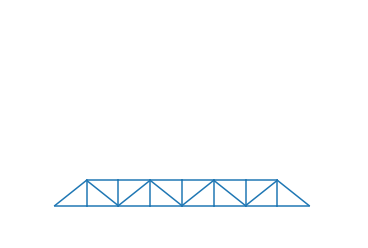

In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

pstr.showStructure()

In [10]:
print(pstr.NODE_LIST)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [11]:
print(pstr.NODE[1].nid,pstr.NODE[1].x)
print(pstr.ELEM)

1 0.0
{1: <__main__.ElementTrussXY object at 0x000002519C777D68>, 2: <__main__.ElementTrussXY object at 0x000002519C777B70>, 3: <__main__.ElementTrussXY object at 0x000002519C777CC0>, 4: <__main__.ElementTrussXY object at 0x000002519C74BEF0>, 5: <__main__.ElementTrussXY object at 0x000002519C74BF28>, 6: <__main__.ElementTrussXY object at 0x000002519C74BF98>, 7: <__main__.ElementTrussXY object at 0x000002519C74BFD0>, 8: <__main__.ElementTrussXY object at 0x000002519C74B438>, 9: <__main__.ElementTrussXY object at 0x000002519C74B908>, 10: <__main__.ElementTrussXY object at 0x000002519C74BF60>, 11: <__main__.ElementTrussXY object at 0x000002519C719908>, 12: <__main__.ElementTrussXY object at 0x000002519C719A90>, 13: <__main__.ElementTrussXY object at 0x000002519C719240>, 14: <__main__.ElementTrussXY object at 0x000002519C719630>, 15: <__main__.ElementTrussXY object at 0x000002519C719A20>, 16: <__main__.ElementTrussXY object at 0x000002519C719320>, 17: <__main__.ElementTrussXY object at 0x0